In [2]:
from datasets import load_dataset

dataset = load_dataset('snli')

labels = dataset.unique("label").keys()
num_labels = len(labels)
# label -1 is used if the gold label is missing, see: https://github.com/huggingface/datasets/issues/296
# therefore we remove all entries with label -1
dataset = dataset.filter(lambda x: x["label"] != -1)

# shuffle the dataset to avoid any bias
dataset = dataset.shuffle(seed=42)

# rename label to labels, because the model expects a column named labels
dataset = dataset.rename_column("label", "labels")

print(f"{labels=}")
print(f"{num_labels=}")

labels=dict_keys(['test', 'validation', 'train'])
num_labels=3


In [61]:
from transformers import BertModel

import torch.nn as nn

class NLIClassifier(nn.Module):
    def __init__(self, model, num_labels=3, freeze_bert=False):
        super(NLIClassifier, self).__init__()
        self.bert = model
        # freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask, token_type_ids, labels):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Extract [CLS] token representation
        logits = self.classifier(cls_output)
        return logits

model = BertModel.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    torch_dtype="auto",
)
nli_model = NLIClassifier(model, num_labels=3)

In [50]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

# tokenize dataset
tokenized_dataset = dataset.map(lambda x: tokenizer(x["premise"], x["hypothesis"], add_special_tokens=True, truncation=True), batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Map:   0%|          | 0/549367 [00:00<?, ? examples/s]

In [41]:
import torch

criterion = nn.CrossEntropyLoss()
tokenized_dataset

DatasetDict({
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9824
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9842
    })
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 549367
    })
})

In [71]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

# remove all text columns, because they are already tokenized
#tokenized_dataset = tokenized_dataset.remove_columns(["premise", "hypothesis"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)
traindataloader = DataLoader(tokenized_dataset["train"].select(range(100)), batch_size=32, shuffle=True, collate_fn=data_collator)

In [14]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [32]:
class TrainingResults:
    def __init__(self):
        self.losses = []
        self.accuracies = []
        self.epoch = []

    def add(self, loss, accuracy, epoch):
        self.losses.append(loss.item())
        self.accuracies.append(accuracy)
        self.epoch.append(epoch)

    def __str__(self):
        return f"Loss: {self.losses}, Accuracy: {self.accuracies}, Epoch: {self.epoch}"

In [72]:
from torch.optim import AdamW
# optimizer = AdamW(nli_model.parameters(),lr=5e-5)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, nli_model.parameters()), lr=5e-5)

from transformers import get_scheduler
num_epochs=3
num_training_steps = num_epochs * len(traindataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
nli_model.to(device)
nli_model.train()
results = TrainingResults()

for epoch in range(num_epochs):
    i = 1
    for batch in traindataloader:
        optimizer.zero_grad()
        outputs = nli_model(**batch)
        loss = criterion(outputs, batch["labels"])
        accuracy = (torch.argmax(outputs, dim=-1) == batch["labels"]).float().mean()
        current_epoch = i / len(traindataloader) + epoch
        results.add(loss, accuracy.item(), current_epoch)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
        i += 1

  0%|          | 0/12 [00:00<?, ?it/s]

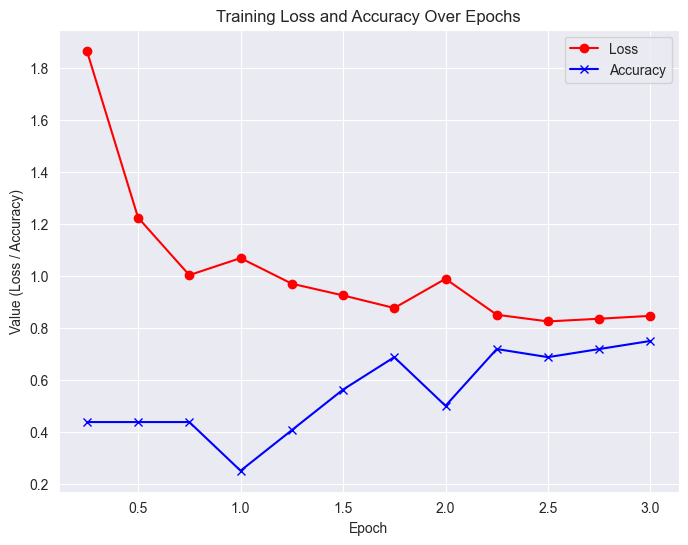

In [75]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(8, 6))

# Plot Loss vs Epoch
plt.plot(results.epoch, results.losses, label='Loss', color='red', marker='o')

# Plot Accuracy vs Epoch
plt.plot(results.epoch, results.accuracies, label='Accuracy', color='blue', marker='x')

# Labels and Title
plt.ylabel('Value (Loss / Accuracy)')
plt.xlabel('Epoch')
plt.title('Training Loss and Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
testdataloader = DataLoader(tokenized_dataset["test"].select(range(100)), batch_size=32, shuffle=True, collate_fn=data_collator)

In [18]:
import evaluate

metric = evaluate.load("accuracy")
nli_model.eval()
for batch in testdataloader:
    # for model inference we don't need gradients
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.5}